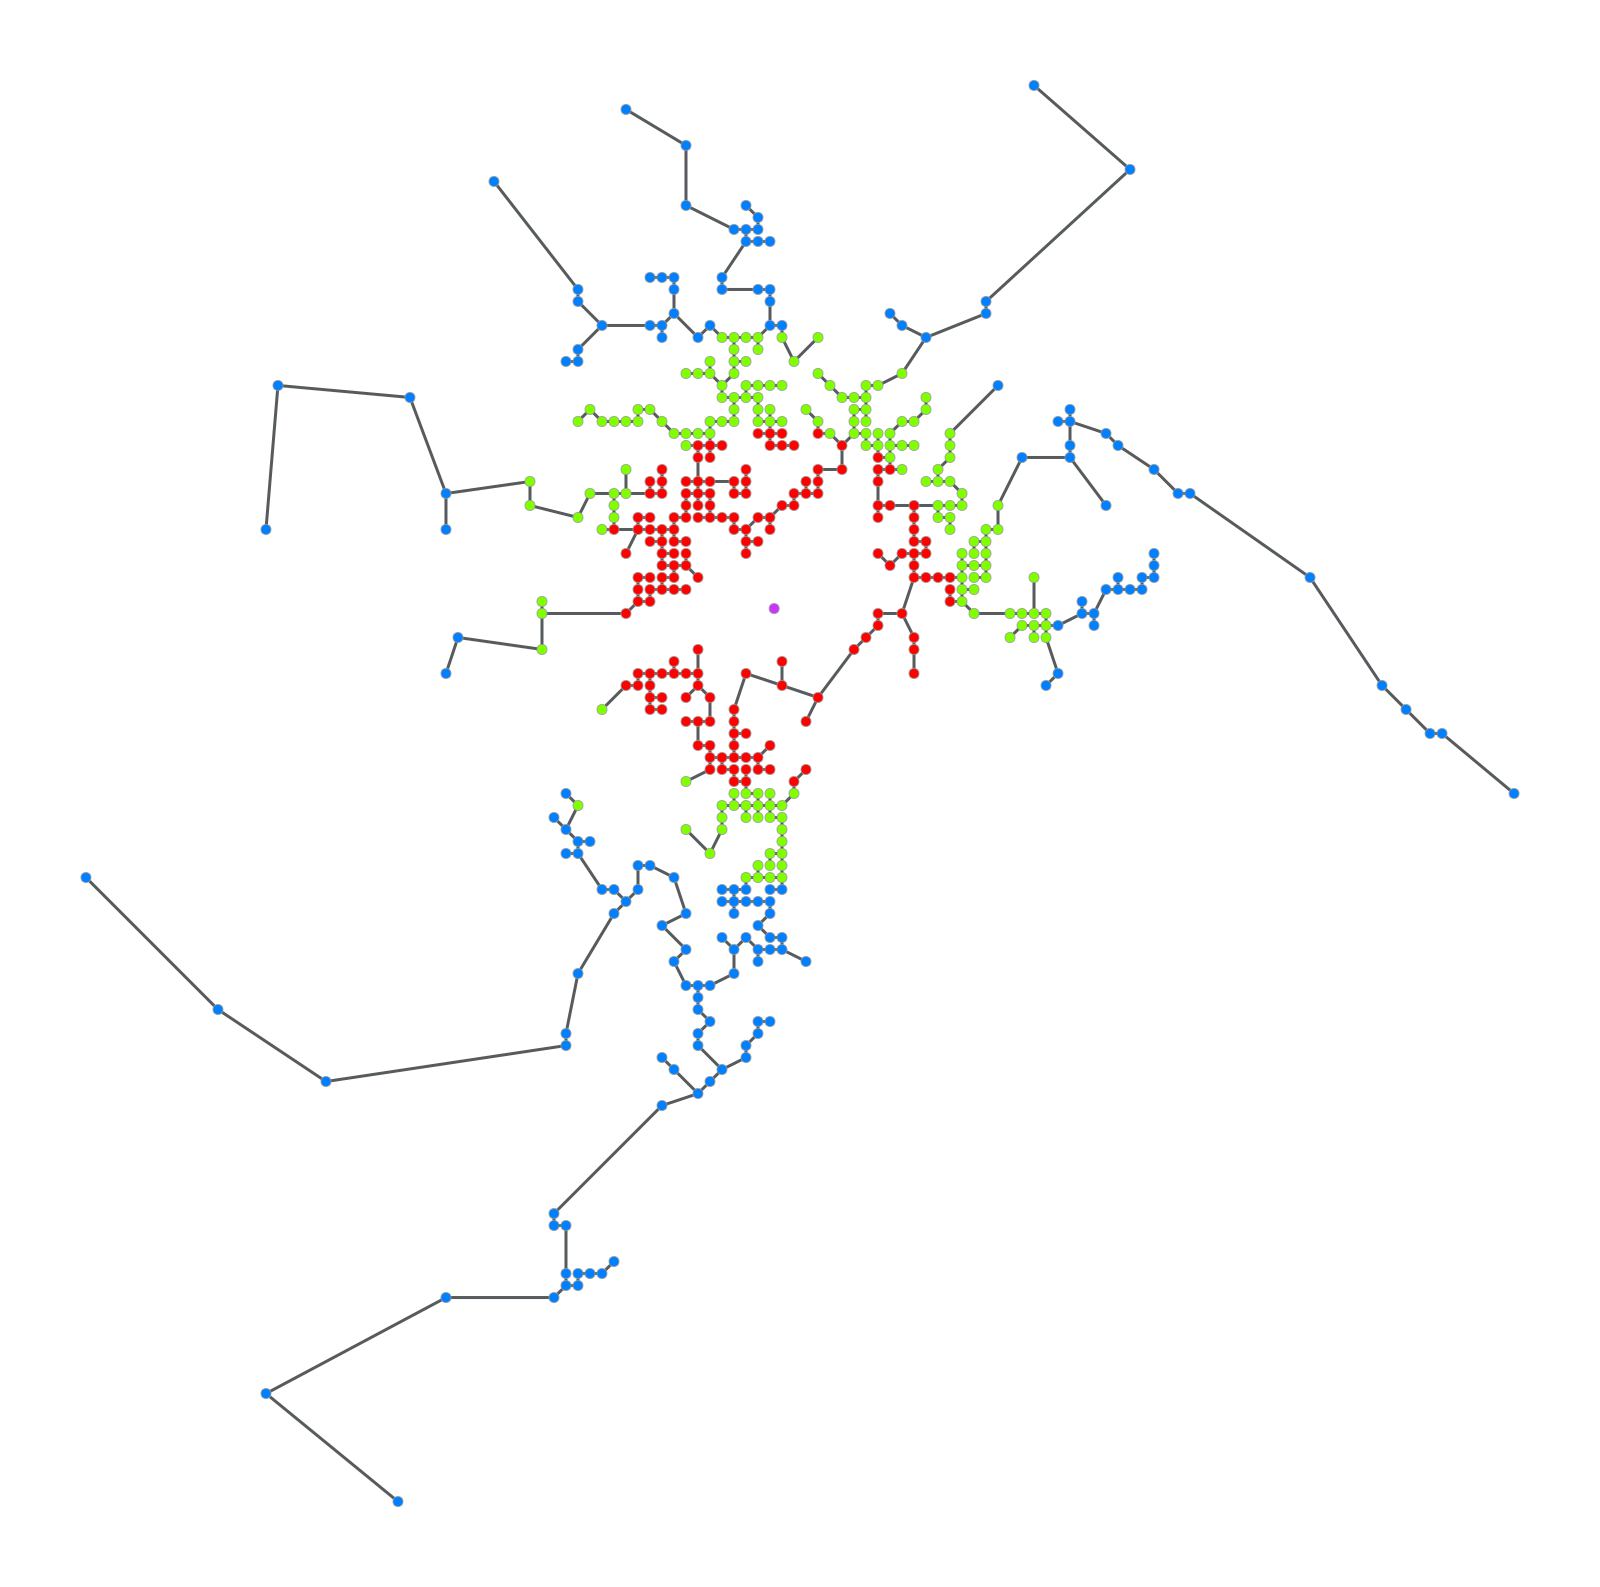

In [32]:
import numpy as np
import graph_tool.all as gt
import python_codes.files_operators as fo
import matplotlib.pyplot as plt

# 读取图数据
read_graph, read_pos = fo.read_files("./networks_date/tokyo_pop_500_mst.net", False)

# 创建并赋值位置属性，确保数据为 float
pos = read_graph.new_vertex_property("vector<double>")
positions = []

for v in read_graph.vertices():
    coords = read_pos[v]
    coords_float = [float(coords[0]), float(coords[1])]  # 强制转换为 float
    pos[v] = coords_float
    positions.append(coords_float)

positions = np.array(positions, dtype=np.float64)  # 确保是 numpy float 数组

# **计算网络的质心（替换原 Bounding Box 中心）**
center_x, center_y = np.mean(positions, axis=0)

# 计算节点到质心的距离并排序
distances = np.linalg.norm(positions - np.array([center_x, center_y]), axis=1)
sorted_indices = np.argsort(distances)
num_nodes = len(positions)

# **根据距离将节点分为三环**
node_layers = np.zeros(num_nodes, dtype=int)
for idx, node_idx in enumerate(sorted_indices):
    if idx < num_nodes / 3:
        node_layers[node_idx] = 1
    elif idx < 2 * num_nodes / 3:
        node_layers[node_idx] = 2
    else:
        node_layers[node_idx] = 3

# 创建节点颜色属性
layer_prop = read_graph.new_vertex_property("int")
for idx, layer in enumerate(node_layers):
    layer_prop[read_graph.vertex(idx)] = layer

# **映射颜色**
color_map = {1: (1, 0, 0, 1), 2: (0.5, 1, 0, 1), 3: (0, 0.5, 1, 1)}  # 颜色需为 RGBA 格式
vertex_colors = read_graph.new_vertex_property("vector<double>")

for v in read_graph.vertices():
    vertex_colors[v] = color_map[layer_prop[v]]

# **标记质心点**
center_vertex_color = read_graph.new_vertex_property("vector<double>")
for v in read_graph.vertices():
    center_vertex_color[v] = vertex_colors[v]  # 默认使用原颜色

# **创建一个额外的虚拟节点用于标记质心**
center_v = read_graph.add_vertex()
pos[center_v] = [center_x, center_y]
center_vertex_color[center_v] = (0.8, 0.2, 1, 1)  # 质心颜色

# **绘图**
gt.graph_draw(read_graph,
              pos=pos,
              vertex_fill_color=center_vertex_color,  # 确保颜色映射正确
              vertex_size=5,
              edge_pen_width=1.5,
              output_size=(800, 800),)
gt.graph_draw(read_graph,
              pos=pos,
              vertex_fill_color=center_vertex_color,  # 确保颜色映射正确
              vertex_size=5,
              edge_pen_width=1.5,
              output_size=(800, 800),
              output=f"tokyo_500_pop_zhixin.png")
plt.show()


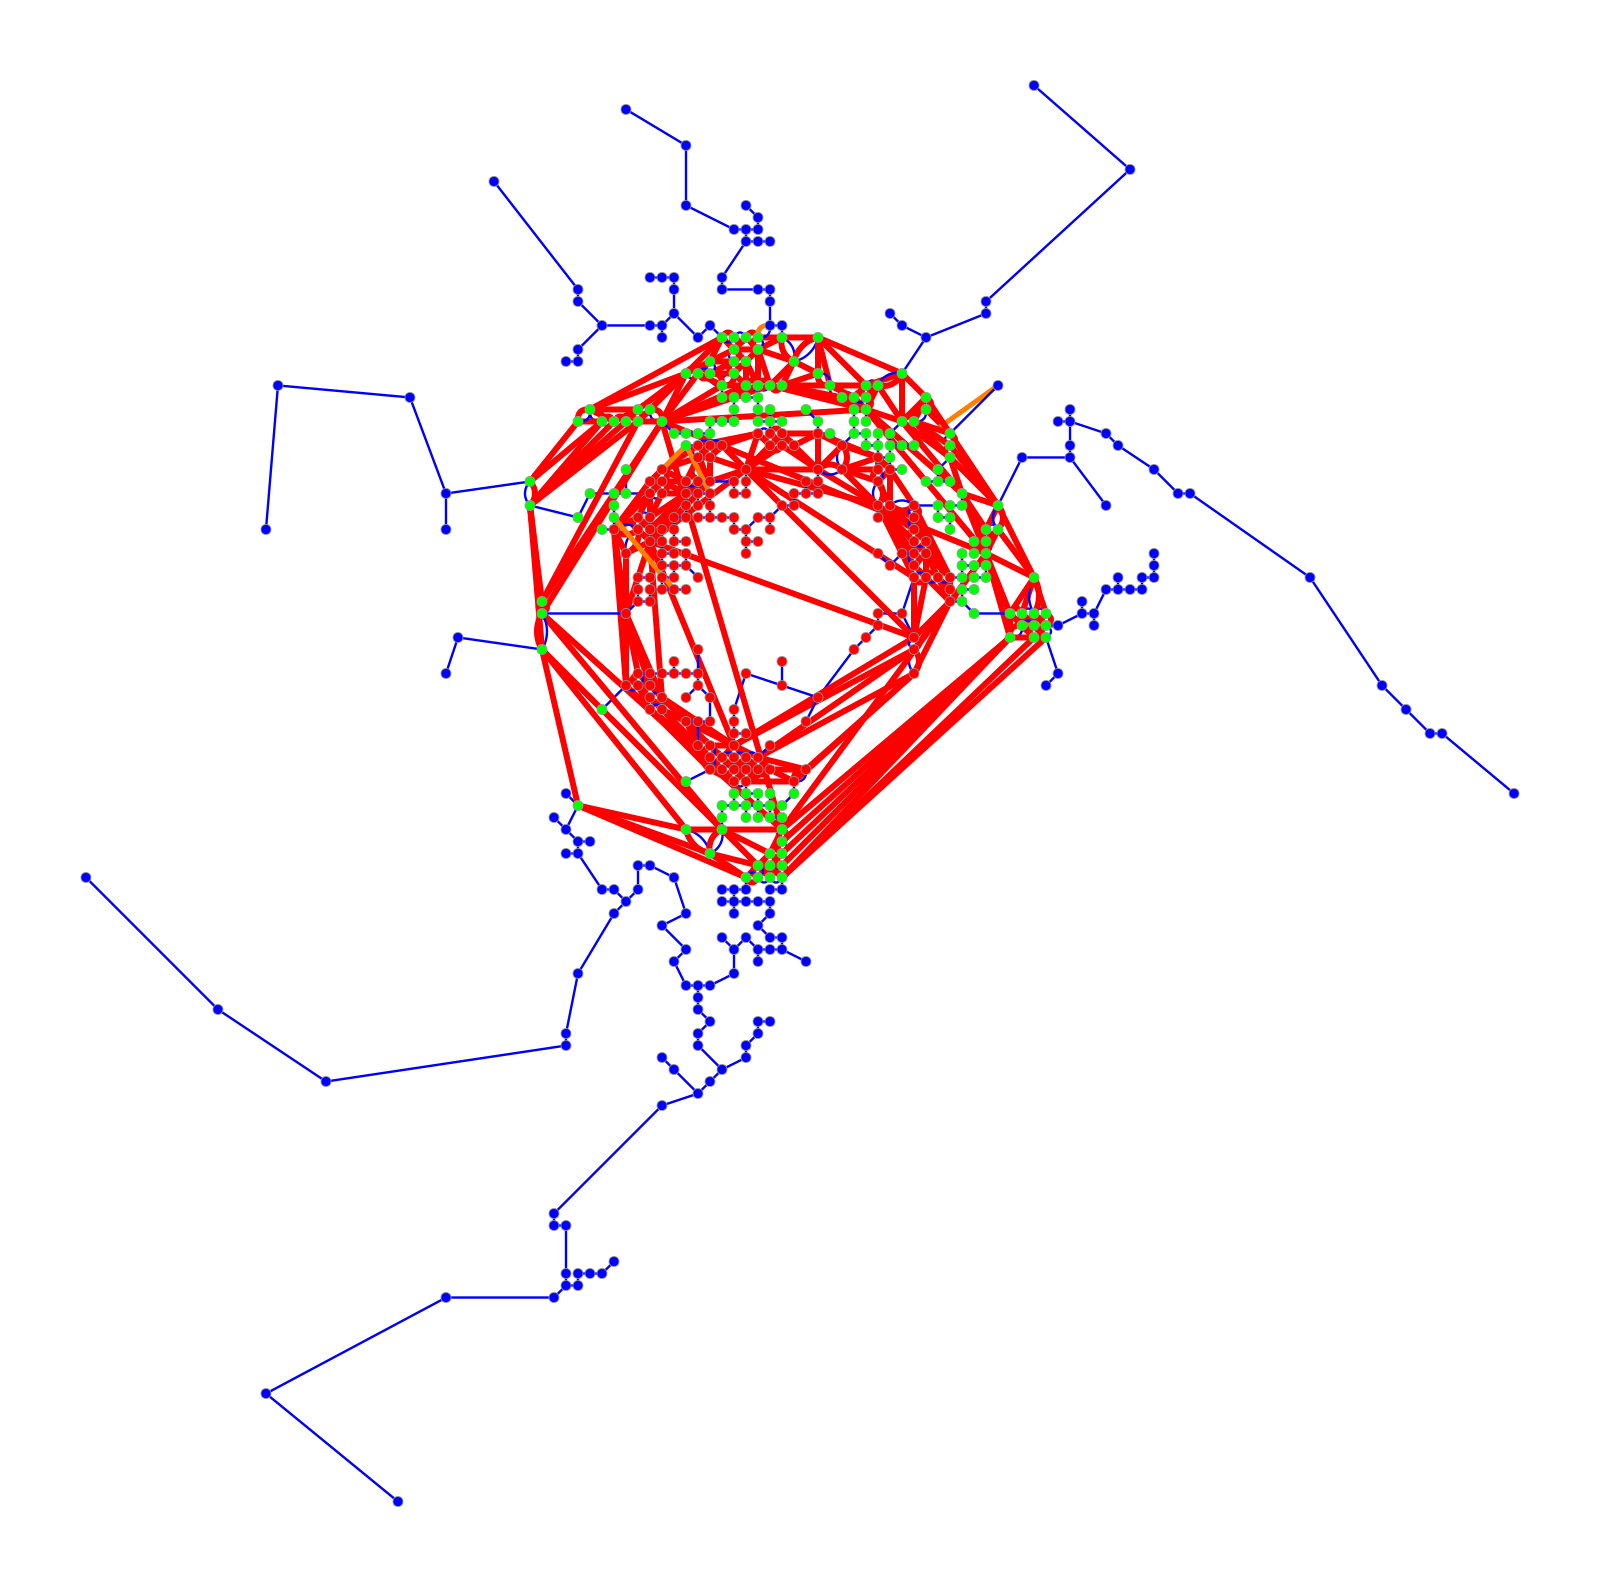

In [23]:
import numpy as np
import random
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay
from graph_tool.all import Graph, graph_draw, min_spanning_tree
import python_codes.files_operators as fo

# 读取图数据
read_graph, read_pos = fo.read_files("./networks_date/tokyo_pop_500_mst.net", False)

# 创建并赋值位置属性
pos = read_graph.new_vertex_property("vector<double>")
positions = []
for v in read_graph.vertices():
    coords = read_pos[v]
    coords_float = [float(coords[0]), float(coords[1])]
    pos[v] = coords_float
    positions.append(coords_float)

positions = np.array(positions, dtype=np.float64)

# 计算网络的质心
center_x, center_y = np.mean(positions, axis=0)

# 计算节点到质心的距离并排序
distances = np.linalg.norm(positions - np.array([center_x, center_y]), axis=1)
sorted_indices = np.argsort(distances)
num_nodes = len(positions)

# **基于数量均等划分三层**
node_layers = np.zeros(num_nodes, dtype=int)
for idx, node_idx in enumerate(sorted_indices):
    if idx < num_nodes / 3:
        node_layers[node_idx] = 1  # 第一层
    elif idx < 2 * num_nodes / 3:
        node_layers[node_idx] = 2  # 第二层
    else:
        node_layers[node_idx] = 3  # 第三层

# 计算 MST 作为基础结构
mst_edges = min_spanning_tree(read_graph)

# 复制 MST 作为基础网络
new_graph = Graph(read_graph)
edge_weights = new_graph.new_edge_property("double")

# 颜色映射：不同层使用不同颜色
color_map = {1: (1, 0, 0, 1), 2: (0, 1, 0, 1), 3: (0, 0, 1, 1)}
vertex_colors = new_graph.new_vertex_property("vector<double>")

for v in new_graph.vertices():
    vertex_colors[v] = color_map[node_layers[int(v)]]

# **基于 Delaunay 生成两条环路（作为分割线）**
loop_edges = []

# 获取两条环的边界节点
layer1_boundary = [v for v in sorted_indices if node_layers[v] == 1][-int(num_nodes/6):]  # 第一层最外围
layer2_boundary = [v for v in sorted_indices if node_layers[v] == 2][-int(num_nodes/6):]  # 第二层最外围

# **Delaunay 生成环路**
def generate_delaunay_loop(graph, positions, boundary_nodes):
    delaunay = Delaunay(positions[boundary_nodes])  # 计算 Delaunay 三角剖分
    edges = set()
    for simplex in delaunay.simplices:
        for i in range(3):
            for j in range(i + 1, 3):
                v1, v2 = boundary_nodes[simplex[i]], boundary_nodes[simplex[j]]
                edges.add((min(v1, v2), max(v1, v2)))  # 避免重复边

    loop_edges = []
    for v1, v2 in edges:
        edge = graph.add_edge(v1, v2)
        loop_edges.append(edge)

    return loop_edges

# 生成第一层到第二层的环路
loop_edges.extend(generate_delaunay_loop(new_graph, positions, layer1_boundary))

# 生成第二层到第三层的环路
loop_edges.extend(generate_delaunay_loop(new_graph, positions, layer2_boundary))

# **添加跨层桥接边**
bridge_edges = []
num_bridges = 3
for lower_layer in range(1, 3):
    upper_layer = lower_layer + 1
    lower_nodes = [v for v in sorted_indices if node_layers[v] == lower_layer]
    upper_nodes = [v for v in sorted_indices if node_layers[v] == upper_layer]

    if lower_nodes and upper_nodes:
        for i in range(num_bridges):
            v1 = random.choice(lower_nodes)
            v2 = min(upper_nodes, key=lambda u: np.linalg.norm(np.array(positions[v1]) - np.array(positions[u])))
            edge = new_graph.add_edge(v1, v2)
            bridge_edges.append(edge)

# **设置边颜色和宽度**
edge_colors = new_graph.new_edge_property("vector<double>")
edge_pen_width = new_graph.new_edge_property("double")

for edge in new_graph.edges():
    if edge in loop_edges:  # 仅两条环路（红色加粗）
        edge_colors[edge] = [1, 0, 0, 1]
        edge_pen_width[edge] = 3.0
    elif edge in bridge_edges:  # 桥接边（橙色）
        edge_colors[edge] = [1, 0.5, 0, 1]
        edge_pen_width[edge] = 2.5
    else:  # 其他 MST 边（默认蓝色）
        edge_colors[edge] = [0, 0, 1, 1]
        edge_pen_width[edge] = 1.2

# **绘图**
graph_draw(new_graph,
           pos=pos,
           vertex_fill_color=vertex_colors,  # 保留节点颜色
           edge_color=edge_colors,
           edge_pen_width=edge_pen_width,
           vertex_size=5,
           output_size=(800, 800))
plt.show()


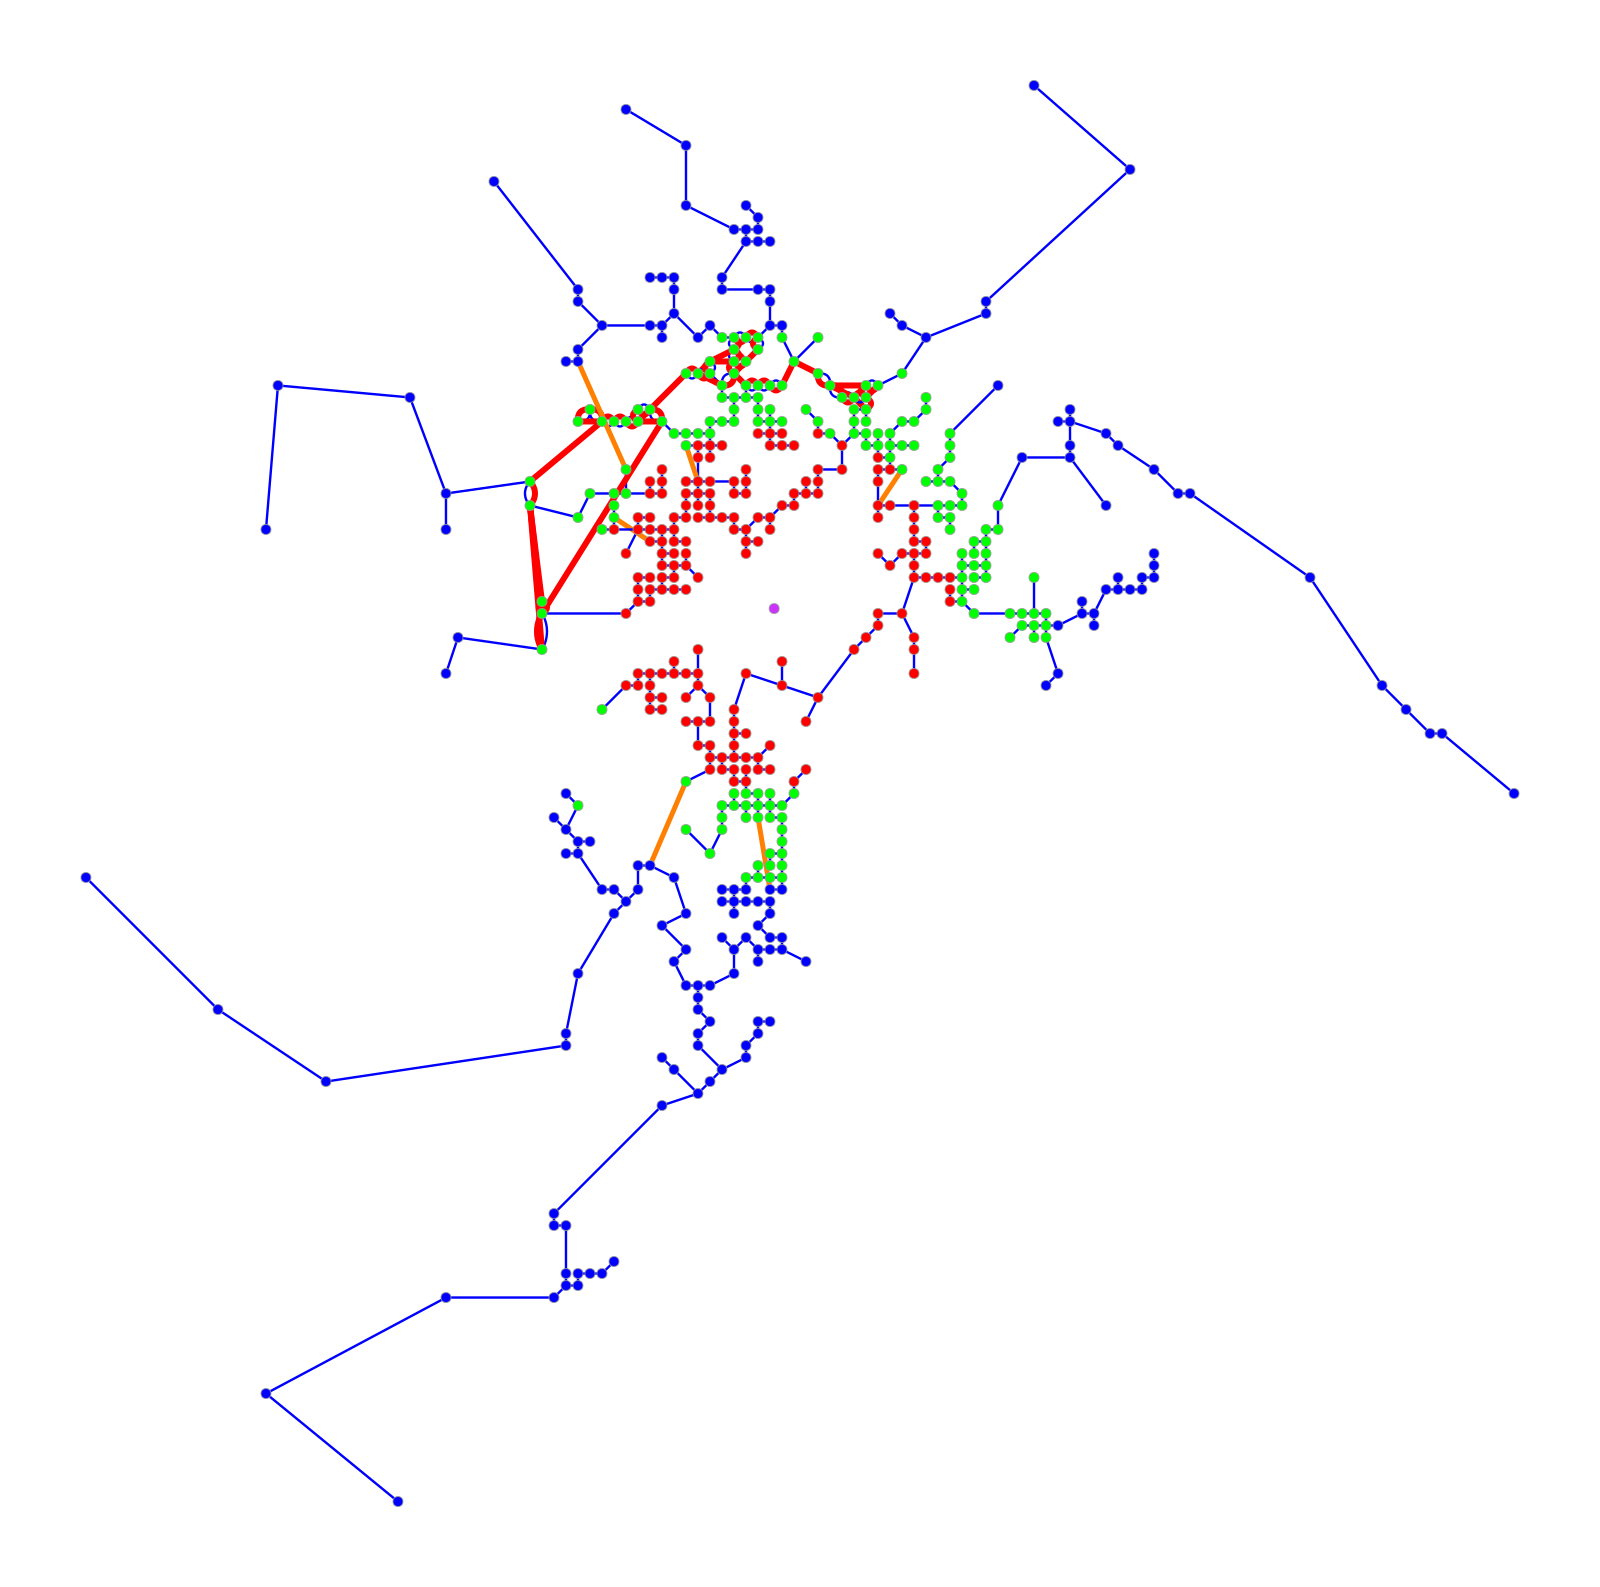

In [31]:
import numpy as np
import random
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay
from graph_tool.all import Graph, graph_draw, min_spanning_tree
import python_codes.files_operators as fo

# 读取图数据
read_graph, read_pos = fo.read_files("./networks_date/tokyo_pop_500_mst.net", False)

# 创建并赋值位置属性
pos = read_graph.new_vertex_property("vector<double>")
positions = []
for v in read_graph.vertices():
    coords = read_pos[v]
    coords_float = [float(coords[0]), float(coords[1])]
    pos[v] = coords_float
    positions.append(coords_float)

positions = np.array(positions, dtype=np.float64)

# 计算网络的质心
center_x, center_y = np.mean(positions, axis=0)

# 计算节点到质心的距离并排序
distances = np.linalg.norm(positions - np.array([center_x, center_y]), axis=1)
sorted_indices = np.argsort(distances)
num_nodes = len(positions)

# **基于数量均等划分三层**
node_layers = np.zeros(num_nodes, dtype=int)
for idx, node_idx in enumerate(sorted_indices):
    if idx < num_nodes / 3:
        node_layers[node_idx] = 1
    elif idx < 2 * num_nodes / 3:
        node_layers[node_idx] = 2
    else:
        node_layers[node_idx] = 3

# 计算 MST 作为基础结构
mst_edges = min_spanning_tree(read_graph)

# 复制 MST 作为基础网络
new_graph = Graph(read_graph)
edge_weights = new_graph.new_edge_property("double")

# 颜色映射：不同层使用不同颜色
color_map = {1: (1, 0, 0, 1), 2: (0, 1, 0, 1), 3: (0, 0, 1, 1)}
vertex_colors = new_graph.new_vertex_property("vector<double>")

for v in new_graph.vertices():
    vertex_colors[v] = color_map[node_layers[int(v)]]

# 添加质心（紫色）
center_vertex = new_graph.add_vertex()
pos[center_vertex] = [center_x, center_y]
vertex_colors[center_vertex] = (0.8, 0.2, 1, 1)  # 紫色圆心

# **基于 Delaunay 生成唯一的一条完整环路**
def generate_single_delaunay_loop(graph, positions, boundary_nodes):
    if len(boundary_nodes) < 3:
        return []  # 避免 Delaunay 失败

    delaunay = Delaunay(positions[boundary_nodes])
    edges = set()
    for simplex in delaunay.simplices:
        for i in range(3):
            for j in range(i + 1, 3):
                v1, v2 = boundary_nodes[simplex[i]], boundary_nodes[simplex[j]]
                edges.add((min(v1, v2), max(v1, v2)))

    # 生成环路
    loop_edges = []
    visited = set()
    start_node = boundary_nodes[0]
    current_node = start_node
    while len(visited) < len(boundary_nodes):
        visited.add(current_node)
        possible_edges = [(v1, v2) for v1, v2 in edges if v1 == current_node or v2 == current_node]
        if not possible_edges:
            break  # 避免 min() 为空
        next_edge = min(possible_edges, key=lambda e: np.linalg.norm(positions[e[0]] - positions[e[1]]))
        edges.remove(next_edge)
        next_node = next_edge[0] if next_edge[1] == current_node else next_edge[1]
        loop_edges.append(graph.add_edge(current_node, next_node))
        current_node = next_node
        if current_node == start_node and len(visited) >= len(boundary_nodes):
            break

    return loop_edges

# 获取层 2 到层 3 之间的边界节点（用于唯一环路）
outer_boundary = [v for v in sorted_indices if node_layers[v] == 2][-int(num_nodes / 6):]

# 生成唯一的一条环路
loop_edges = generate_single_delaunay_loop(new_graph, positions, outer_boundary)

# **添加跨层桥接边**
bridge_edges = []
num_bridges = 3
for lower_layer in range(1, 3):
    upper_layer = lower_layer + 1
    lower_nodes = [v for v in sorted_indices if node_layers[v] == lower_layer]
    upper_nodes = [v for v in sorted_indices if node_layers[v] == upper_layer]

    if lower_nodes and upper_nodes:
        for i in range(num_bridges):
            v1 = random.choice(lower_nodes)
            if upper_nodes:  # 确保 upper_nodes 不是空的
                v2 = min(upper_nodes, key=lambda u: np.linalg.norm(np.array(positions[v1]) - np.array(positions[u])))
                edge = new_graph.add_edge(v1, v2)
                bridge_edges.append(edge)

# **设置边颜色和宽度**
edge_colors = new_graph.new_edge_property("vector<double>")
edge_pen_width = new_graph.new_edge_property("double")

for edge in new_graph.edges():
    if edge in loop_edges:
        edge_colors[edge] = [1, 0, 0, 1]  # 红色环路
        edge_pen_width[edge] = 3.0
    elif edge in bridge_edges:
        edge_colors[edge] = [1, 0.5, 0, 1]  # 橙色桥接边
        edge_pen_width[edge] = 2.5
    else:
        edge_colors[edge] = [0, 0, 1, 1]  # 蓝色 MST
        edge_pen_width[edge] = 1.2

# **绘图**
graph_draw(new_graph,
           pos=pos,
           vertex_fill_color=vertex_colors,
           edge_color=edge_colors,
           edge_pen_width=edge_pen_width,
           vertex_size=5,
           output_size=(800, 800))
plt.show()
